In [1]:
import os
import sys
from collections import OrderedDict

In [2]:
sys.path.append("../..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [5]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [6]:
class Edge1(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.SubDomain):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05


In [29]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Subdomains
        self.add_subdomain(Edge1(), 2)
        self.add_subdomain(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        sd = self.mesh.sd
        left = numpy.sum(vol[sd == 2])
        right = numpy.sum(vol[sd == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [21]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [22]:
model.listOfReactions

OrderedDict([('rxn24f270ce_5034_4020_ada4_70bf17ead6a0',
              <spatialpy.Model.Reaction at 0x7f28e87e1a60>),
             ('rxn70aa045b_9d02_4fa8_97f0_ff15e684545d',
              <spatialpy.Model.Reaction at 0x7f28e87e1d00>),
             ('rxnfe93573a_d313_49d2_9831_432b40fcd06c',
              <spatialpy.Model.Reaction at 0x7f28e87e1ac0>)])

In [23]:
from spatialpy.nsmsolver import NSMSolver

In [24]:
#result = model.run(report_level=2)
sol = NSMSolver(model, debug_level=0)
sol.h = 0.8
print("h="+str(sol.h))
%time sol.compile()

h=0.8
CPU times: user 26.1 ms, sys: 4.35 ms, total: 30.4 ms
Wall time: 2.82 s


In [25]:
%time result = sol.run()

CPU times: user 5.69 ms, sys: 16.3 ms, total: 22 ms
Wall time: 2.93 s


read_step(0) opening '/tmp/spatialpy_result_muiph44u/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_muiph44u/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_muiph44u/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_muiph44u/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_muiph44u/output4.vtk'
read_step(5) opening '/tmp/spatialpy_result_muiph44u/output5.vtk'
read_step(6) opening '/tmp/spatialpy_result_muiph44u/output6.vtk'
read_step(7) opening '/tmp/spatialpy_result_muiph44u/output7.vtk'
read_step(8) opening '/tmp/spatialpy_result_muiph44u/output8.vtk'
read_step(9) opening '/tmp/spatialpy_result_muiph44u/output9.vtk'
read_step(10) opening '/tmp/spatialpy_result_muiph44u/output10.vtk'
read_step(11) opening '/tmp/spatialpy_result_muiph44u/output11.vtk'
read_step(12) opening '/tmp/spatialpy_result_muiph44u/output12.vtk'
read_step(13) opening '/tmp/spatialpy_result_muiph44u/output13.vtk'
read_step(14) opening '/tmp/spatialpy_result_muiph44u/output14.vtk'


read_step(141) opening '/tmp/spatialpy_result_muiph44u/output141.vtk'
read_step(142) opening '/tmp/spatialpy_result_muiph44u/output142.vtk'
read_step(143) opening '/tmp/spatialpy_result_muiph44u/output143.vtk'
read_step(144) opening '/tmp/spatialpy_result_muiph44u/output144.vtk'
read_step(145) opening '/tmp/spatialpy_result_muiph44u/output145.vtk'
read_step(146) opening '/tmp/spatialpy_result_muiph44u/output146.vtk'
read_step(147) opening '/tmp/spatialpy_result_muiph44u/output147.vtk'
read_step(148) opening '/tmp/spatialpy_result_muiph44u/output148.vtk'
read_step(149) opening '/tmp/spatialpy_result_muiph44u/output149.vtk'
read_step(150) opening '/tmp/spatialpy_result_muiph44u/output150.vtk'
read_step(151) opening '/tmp/spatialpy_result_muiph44u/output151.vtk'
read_step(152) opening '/tmp/spatialpy_result_muiph44u/output152.vtk'
read_step(153) opening '/tmp/spatialpy_result_muiph44u/output153.vtk'
read_step(154) opening '/tmp/spatialpy_result_muiph44u/output154.vtk'
read_step(155) openi

read_step(269) opening '/tmp/spatialpy_result_muiph44u/output269.vtk'
read_step(270) opening '/tmp/spatialpy_result_muiph44u/output270.vtk'
read_step(271) opening '/tmp/spatialpy_result_muiph44u/output271.vtk'
read_step(272) opening '/tmp/spatialpy_result_muiph44u/output272.vtk'
read_step(273) opening '/tmp/spatialpy_result_muiph44u/output273.vtk'
read_step(274) opening '/tmp/spatialpy_result_muiph44u/output274.vtk'
read_step(275) opening '/tmp/spatialpy_result_muiph44u/output275.vtk'
read_step(276) opening '/tmp/spatialpy_result_muiph44u/output276.vtk'
read_step(277) opening '/tmp/spatialpy_result_muiph44u/output277.vtk'
read_step(278) opening '/tmp/spatialpy_result_muiph44u/output278.vtk'
read_step(279) opening '/tmp/spatialpy_result_muiph44u/output279.vtk'
read_step(280) opening '/tmp/spatialpy_result_muiph44u/output280.vtk'
read_step(281) opening '/tmp/spatialpy_result_muiph44u/output281.vtk'
read_step(282) opening '/tmp/spatialpy_result_muiph44u/output282.vtk'
read_step(283) openi

read_step(399) opening '/tmp/spatialpy_result_muiph44u/output399.vtk'
read_step(400) opening '/tmp/spatialpy_result_muiph44u/output400.vtk'
read_step(401) opening '/tmp/spatialpy_result_muiph44u/output401.vtk'
read_step(402) opening '/tmp/spatialpy_result_muiph44u/output402.vtk'
read_step(403) opening '/tmp/spatialpy_result_muiph44u/output403.vtk'
read_step(404) opening '/tmp/spatialpy_result_muiph44u/output404.vtk'
read_step(405) opening '/tmp/spatialpy_result_muiph44u/output405.vtk'
read_step(406) opening '/tmp/spatialpy_result_muiph44u/output406.vtk'
read_step(407) opening '/tmp/spatialpy_result_muiph44u/output407.vtk'
read_step(408) opening '/tmp/spatialpy_result_muiph44u/output408.vtk'
read_step(409) opening '/tmp/spatialpy_result_muiph44u/output409.vtk'
read_step(410) opening '/tmp/spatialpy_result_muiph44u/output410.vtk'
read_step(411) opening '/tmp/spatialpy_result_muiph44u/output411.vtk'
read_step(412) opening '/tmp/spatialpy_result_muiph44u/output412.vtk'
read_step(413) openi

read_step(17) opening '/tmp/spatialpy_result_muiph44u/output17.vtk'
read_step(18) opening '/tmp/spatialpy_result_muiph44u/output18.vtk'
read_step(19) opening '/tmp/spatialpy_result_muiph44u/output19.vtk'
read_step(20) opening '/tmp/spatialpy_result_muiph44u/output20.vtk'
read_step(21) opening '/tmp/spatialpy_result_muiph44u/output21.vtk'
read_step(22) opening '/tmp/spatialpy_result_muiph44u/output22.vtk'
read_step(23) opening '/tmp/spatialpy_result_muiph44u/output23.vtk'
read_step(24) opening '/tmp/spatialpy_result_muiph44u/output24.vtk'
read_step(25) opening '/tmp/spatialpy_result_muiph44u/output25.vtk'
read_step(26) opening '/tmp/spatialpy_result_muiph44u/output26.vtk'
read_step(27) opening '/tmp/spatialpy_result_muiph44u/output27.vtk'
read_step(28) opening '/tmp/spatialpy_result_muiph44u/output28.vtk'
read_step(29) opening '/tmp/spatialpy_result_muiph44u/output29.vtk'
read_step(30) opening '/tmp/spatialpy_result_muiph44u/output30.vtk'
read_step(31) opening '/tmp/spatialpy_result_mui

read_step(138) opening '/tmp/spatialpy_result_muiph44u/output138.vtk'
read_step(139) opening '/tmp/spatialpy_result_muiph44u/output139.vtk'
read_step(140) opening '/tmp/spatialpy_result_muiph44u/output140.vtk'
read_step(141) opening '/tmp/spatialpy_result_muiph44u/output141.vtk'
read_step(142) opening '/tmp/spatialpy_result_muiph44u/output142.vtk'
read_step(143) opening '/tmp/spatialpy_result_muiph44u/output143.vtk'
read_step(144) opening '/tmp/spatialpy_result_muiph44u/output144.vtk'
read_step(145) opening '/tmp/spatialpy_result_muiph44u/output145.vtk'
read_step(146) opening '/tmp/spatialpy_result_muiph44u/output146.vtk'
read_step(147) opening '/tmp/spatialpy_result_muiph44u/output147.vtk'
read_step(148) opening '/tmp/spatialpy_result_muiph44u/output148.vtk'
read_step(149) opening '/tmp/spatialpy_result_muiph44u/output149.vtk'
read_step(150) opening '/tmp/spatialpy_result_muiph44u/output150.vtk'
read_step(151) opening '/tmp/spatialpy_result_muiph44u/output151.vtk'
read_step(152) openi

read_step(278) opening '/tmp/spatialpy_result_muiph44u/output278.vtk'
read_step(279) opening '/tmp/spatialpy_result_muiph44u/output279.vtk'
read_step(280) opening '/tmp/spatialpy_result_muiph44u/output280.vtk'
read_step(281) opening '/tmp/spatialpy_result_muiph44u/output281.vtk'
read_step(282) opening '/tmp/spatialpy_result_muiph44u/output282.vtk'
read_step(283) opening '/tmp/spatialpy_result_muiph44u/output283.vtk'
read_step(284) opening '/tmp/spatialpy_result_muiph44u/output284.vtk'
read_step(285) opening '/tmp/spatialpy_result_muiph44u/output285.vtk'
read_step(286) opening '/tmp/spatialpy_result_muiph44u/output286.vtk'
read_step(287) opening '/tmp/spatialpy_result_muiph44u/output287.vtk'
read_step(288) opening '/tmp/spatialpy_result_muiph44u/output288.vtk'
read_step(289) opening '/tmp/spatialpy_result_muiph44u/output289.vtk'
read_step(290) opening '/tmp/spatialpy_result_muiph44u/output290.vtk'
read_step(291) opening '/tmp/spatialpy_result_muiph44u/output291.vtk'
read_step(292) openi

read_step(405) opening '/tmp/spatialpy_result_muiph44u/output405.vtk'
read_step(406) opening '/tmp/spatialpy_result_muiph44u/output406.vtk'
read_step(407) opening '/tmp/spatialpy_result_muiph44u/output407.vtk'
read_step(408) opening '/tmp/spatialpy_result_muiph44u/output408.vtk'
read_step(409) opening '/tmp/spatialpy_result_muiph44u/output409.vtk'
read_step(410) opening '/tmp/spatialpy_result_muiph44u/output410.vtk'
read_step(411) opening '/tmp/spatialpy_result_muiph44u/output411.vtk'
read_step(412) opening '/tmp/spatialpy_result_muiph44u/output412.vtk'
read_step(413) opening '/tmp/spatialpy_result_muiph44u/output413.vtk'
read_step(414) opening '/tmp/spatialpy_result_muiph44u/output414.vtk'
read_step(415) opening '/tmp/spatialpy_result_muiph44u/output415.vtk'
read_step(416) opening '/tmp/spatialpy_result_muiph44u/output416.vtk'
read_step(417) opening '/tmp/spatialpy_result_muiph44u/output417.vtk'
read_step(418) opening '/tmp/spatialpy_result_muiph44u/output418.vtk'
read_step(419) openi

read_step(23) opening '/tmp/spatialpy_result_muiph44u/output23.vtk'
read_step(24) opening '/tmp/spatialpy_result_muiph44u/output24.vtk'
read_step(25) opening '/tmp/spatialpy_result_muiph44u/output25.vtk'
read_step(26) opening '/tmp/spatialpy_result_muiph44u/output26.vtk'
read_step(27) opening '/tmp/spatialpy_result_muiph44u/output27.vtk'
read_step(28) opening '/tmp/spatialpy_result_muiph44u/output28.vtk'
read_step(29) opening '/tmp/spatialpy_result_muiph44u/output29.vtk'
read_step(30) opening '/tmp/spatialpy_result_muiph44u/output30.vtk'
read_step(31) opening '/tmp/spatialpy_result_muiph44u/output31.vtk'
read_step(32) opening '/tmp/spatialpy_result_muiph44u/output32.vtk'
read_step(33) opening '/tmp/spatialpy_result_muiph44u/output33.vtk'
read_step(34) opening '/tmp/spatialpy_result_muiph44u/output34.vtk'
read_step(35) opening '/tmp/spatialpy_result_muiph44u/output35.vtk'
read_step(36) opening '/tmp/spatialpy_result_muiph44u/output36.vtk'
read_step(37) opening '/tmp/spatialpy_result_mui

read_step(146) opening '/tmp/spatialpy_result_muiph44u/output146.vtk'
read_step(147) opening '/tmp/spatialpy_result_muiph44u/output147.vtk'
read_step(148) opening '/tmp/spatialpy_result_muiph44u/output148.vtk'
read_step(149) opening '/tmp/spatialpy_result_muiph44u/output149.vtk'
read_step(150) opening '/tmp/spatialpy_result_muiph44u/output150.vtk'
read_step(151) opening '/tmp/spatialpy_result_muiph44u/output151.vtk'
read_step(152) opening '/tmp/spatialpy_result_muiph44u/output152.vtk'
read_step(153) opening '/tmp/spatialpy_result_muiph44u/output153.vtk'
read_step(154) opening '/tmp/spatialpy_result_muiph44u/output154.vtk'
read_step(155) opening '/tmp/spatialpy_result_muiph44u/output155.vtk'
read_step(156) opening '/tmp/spatialpy_result_muiph44u/output156.vtk'
read_step(157) opening '/tmp/spatialpy_result_muiph44u/output157.vtk'
read_step(158) opening '/tmp/spatialpy_result_muiph44u/output158.vtk'
read_step(159) opening '/tmp/spatialpy_result_muiph44u/output159.vtk'
read_step(160) openi

read_step(270) opening '/tmp/spatialpy_result_muiph44u/output270.vtk'
read_step(271) opening '/tmp/spatialpy_result_muiph44u/output271.vtk'
read_step(272) opening '/tmp/spatialpy_result_muiph44u/output272.vtk'
read_step(273) opening '/tmp/spatialpy_result_muiph44u/output273.vtk'
read_step(274) opening '/tmp/spatialpy_result_muiph44u/output274.vtk'
read_step(275) opening '/tmp/spatialpy_result_muiph44u/output275.vtk'
read_step(276) opening '/tmp/spatialpy_result_muiph44u/output276.vtk'
read_step(277) opening '/tmp/spatialpy_result_muiph44u/output277.vtk'
read_step(278) opening '/tmp/spatialpy_result_muiph44u/output278.vtk'
read_step(279) opening '/tmp/spatialpy_result_muiph44u/output279.vtk'
read_step(280) opening '/tmp/spatialpy_result_muiph44u/output280.vtk'
read_step(281) opening '/tmp/spatialpy_result_muiph44u/output281.vtk'
read_step(282) opening '/tmp/spatialpy_result_muiph44u/output282.vtk'
read_step(283) opening '/tmp/spatialpy_result_muiph44u/output283.vtk'
read_step(284) openi

read_step(388) opening '/tmp/spatialpy_result_muiph44u/output388.vtk'
read_step(389) opening '/tmp/spatialpy_result_muiph44u/output389.vtk'
read_step(390) opening '/tmp/spatialpy_result_muiph44u/output390.vtk'
read_step(391) opening '/tmp/spatialpy_result_muiph44u/output391.vtk'
read_step(392) opening '/tmp/spatialpy_result_muiph44u/output392.vtk'
read_step(393) opening '/tmp/spatialpy_result_muiph44u/output393.vtk'
read_step(394) opening '/tmp/spatialpy_result_muiph44u/output394.vtk'
read_step(395) opening '/tmp/spatialpy_result_muiph44u/output395.vtk'
read_step(396) opening '/tmp/spatialpy_result_muiph44u/output396.vtk'
read_step(397) opening '/tmp/spatialpy_result_muiph44u/output397.vtk'
read_step(398) opening '/tmp/spatialpy_result_muiph44u/output398.vtk'
read_step(399) opening '/tmp/spatialpy_result_muiph44u/output399.vtk'
read_step(400) opening '/tmp/spatialpy_result_muiph44u/output400.vtk'
read_step(401) opening '/tmp/spatialpy_result_muiph44u/output401.vtk'
read_step(402) openi

read_step(38) opening '/tmp/spatialpy_result_muiph44u/output38.vtk'
read_step(39) opening '/tmp/spatialpy_result_muiph44u/output39.vtk'
read_step(40) opening '/tmp/spatialpy_result_muiph44u/output40.vtk'
read_step(41) opening '/tmp/spatialpy_result_muiph44u/output41.vtk'
read_step(42) opening '/tmp/spatialpy_result_muiph44u/output42.vtk'
read_step(43) opening '/tmp/spatialpy_result_muiph44u/output43.vtk'
read_step(44) opening '/tmp/spatialpy_result_muiph44u/output44.vtk'
read_step(45) opening '/tmp/spatialpy_result_muiph44u/output45.vtk'
read_step(46) opening '/tmp/spatialpy_result_muiph44u/output46.vtk'
read_step(47) opening '/tmp/spatialpy_result_muiph44u/output47.vtk'
read_step(48) opening '/tmp/spatialpy_result_muiph44u/output48.vtk'
read_step(49) opening '/tmp/spatialpy_result_muiph44u/output49.vtk'
read_step(50) opening '/tmp/spatialpy_result_muiph44u/output50.vtk'
read_step(51) opening '/tmp/spatialpy_result_muiph44u/output51.vtk'
read_step(52) opening '/tmp/spatialpy_result_mui

read_step(173) opening '/tmp/spatialpy_result_muiph44u/output173.vtk'
read_step(174) opening '/tmp/spatialpy_result_muiph44u/output174.vtk'
read_step(175) opening '/tmp/spatialpy_result_muiph44u/output175.vtk'
read_step(176) opening '/tmp/spatialpy_result_muiph44u/output176.vtk'
read_step(177) opening '/tmp/spatialpy_result_muiph44u/output177.vtk'
read_step(178) opening '/tmp/spatialpy_result_muiph44u/output178.vtk'
read_step(179) opening '/tmp/spatialpy_result_muiph44u/output179.vtk'
read_step(180) opening '/tmp/spatialpy_result_muiph44u/output180.vtk'
read_step(181) opening '/tmp/spatialpy_result_muiph44u/output181.vtk'
read_step(182) opening '/tmp/spatialpy_result_muiph44u/output182.vtk'
read_step(183) opening '/tmp/spatialpy_result_muiph44u/output183.vtk'
read_step(184) opening '/tmp/spatialpy_result_muiph44u/output184.vtk'
read_step(185) opening '/tmp/spatialpy_result_muiph44u/output185.vtk'
read_step(186) opening '/tmp/spatialpy_result_muiph44u/output186.vtk'
read_step(187) openi

read_step(294) opening '/tmp/spatialpy_result_muiph44u/output294.vtk'
read_step(295) opening '/tmp/spatialpy_result_muiph44u/output295.vtk'
read_step(296) opening '/tmp/spatialpy_result_muiph44u/output296.vtk'
read_step(297) opening '/tmp/spatialpy_result_muiph44u/output297.vtk'
read_step(298) opening '/tmp/spatialpy_result_muiph44u/output298.vtk'
read_step(299) opening '/tmp/spatialpy_result_muiph44u/output299.vtk'
read_step(300) opening '/tmp/spatialpy_result_muiph44u/output300.vtk'
read_step(301) opening '/tmp/spatialpy_result_muiph44u/output301.vtk'
read_step(302) opening '/tmp/spatialpy_result_muiph44u/output302.vtk'
read_step(303) opening '/tmp/spatialpy_result_muiph44u/output303.vtk'
read_step(304) opening '/tmp/spatialpy_result_muiph44u/output304.vtk'
read_step(305) opening '/tmp/spatialpy_result_muiph44u/output305.vtk'
read_step(306) opening '/tmp/spatialpy_result_muiph44u/output306.vtk'
read_step(307) opening '/tmp/spatialpy_result_muiph44u/output307.vtk'
read_step(308) openi

read_step(417) opening '/tmp/spatialpy_result_muiph44u/output417.vtk'
read_step(418) opening '/tmp/spatialpy_result_muiph44u/output418.vtk'
read_step(419) opening '/tmp/spatialpy_result_muiph44u/output419.vtk'
read_step(420) opening '/tmp/spatialpy_result_muiph44u/output420.vtk'
read_step(421) opening '/tmp/spatialpy_result_muiph44u/output421.vtk'
read_step(422) opening '/tmp/spatialpy_result_muiph44u/output422.vtk'
read_step(423) opening '/tmp/spatialpy_result_muiph44u/output423.vtk'
read_step(424) opening '/tmp/spatialpy_result_muiph44u/output424.vtk'
read_step(425) opening '/tmp/spatialpy_result_muiph44u/output425.vtk'
read_step(426) opening '/tmp/spatialpy_result_muiph44u/output426.vtk'
read_step(427) opening '/tmp/spatialpy_result_muiph44u/output427.vtk'
read_step(428) opening '/tmp/spatialpy_result_muiph44u/output428.vtk'
read_step(429) opening '/tmp/spatialpy_result_muiph44u/output429.vtk'
read_step(430) opening '/tmp/spatialpy_result_muiph44u/output430.vtk'
read_step(431) openi

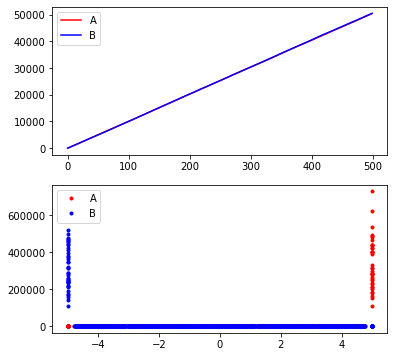

In [26]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
sd = model.mesh.sd
print(numpy.sum(vol[sd == 2]))
print(numpy.sum(vol[sd == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [27]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

read_step(0) opening '/tmp/spatialpy_result_muiph44u/output0.vtk'


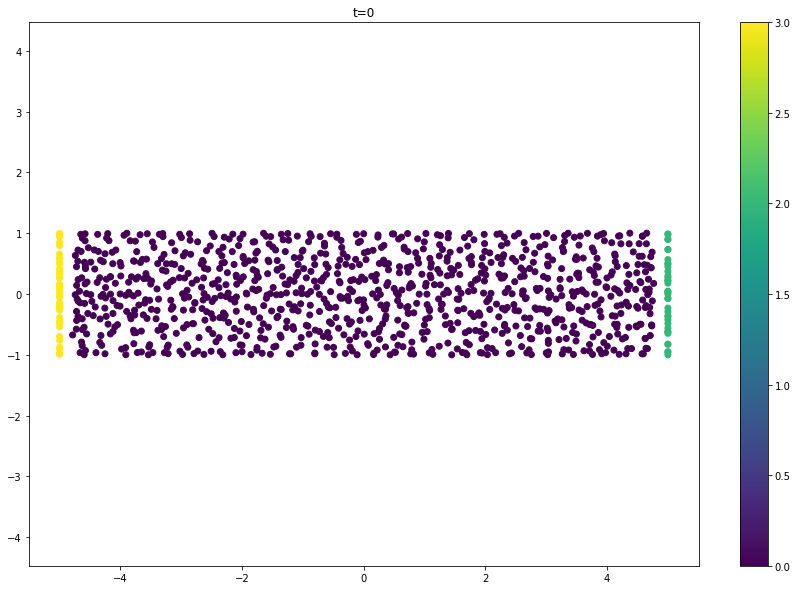

In [28]:
plot_step(0)

In [ ]:
plot_step()